- Check highest magnitude in center
- Add computation of blendedness
- Add plot function for scatter each galaxy on blended image
- clean blended_images.py
- add dedicated function to create images in blended_images.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import cmath as cm
import math
import random
import scipy
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline

Using TensorFlow backend.


In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import plot


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
import blended_images
from importlib import reload

In [33]:
reload(blended_images)

<module 'blended_images' from '/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Image_generation/blended_images.py'>

In [34]:
reload(plot)

<module 'tools_for_VAE.plot' from '../../scripts/tools_for_VAE/tools_for_VAE/plot.py'>

In [35]:
from blended_images import Gal_generator_noisy_test, Gal_generator_noisy_test_2
from multiprocess import *

# Parameters to fix

In [7]:
# Parameters
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Loading catalog

In [8]:
cosmos_cat = galsim.COSMOSCatalog('real_galaxy_catalog_25.2.fits', dir='/sps/lsst/users/barcelin/COSMOS_25.2_training_sample')

## test magnitude min at the center

In [179]:
path, filename = os.path.split('__file__')    
datapath = galsim.meta_data.share_dir
datapath2 = os.path.abspath(os.path.join(path,'/sps/lsst/users/barcelin/EUCLID_Filters/'))

# initialize (pseudo-)random number generator
random_seed = 1234567
rng = galsim.BaseDeviate(random_seed+1)

        # read in the Euclid NIR filters
filter_names_euclid_nir = 'HJY'
filter_names_euclid_vis = 'V'

# read in the LSST filters
filter_names_lsst = 'ugrizy'
filters = {}

In [181]:
for filter_name in filter_names_euclid_nir:
    filter_filename = os.path.join(datapath2, 'Euclid_NISP0.{0}.dat'.format(filter_name))
    filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
    filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

for filter_name in filter_names_euclid_vis:
    filter_filename = os.path.join(datapath2, 'Euclid_VIS.dat'.format(filter_name))
    filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='Angstrom')
    filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

for filter_name in filter_names_lsst:
    filter_filename = os.path.join(datapath, 'bandpasses/LSST_{0}.dat'.format(filter_name))
    filters[filter_name] = galsim.Bandpass(filter_filename, wave_type='nm')
    filters[filter_name] = filters[filter_name].thin(rel_err=1e-4)

In [182]:

galaxies = []
mag=[]
for i in range (4):
    galaxies.append(cosmos_cat.makeGalaxy(np.random.randint(cosmos_cat.nobjects), gal_type='parametric', chromatic=True, noise_pad_size = 0))
    mag.append(galaxies[i].calculateMagnitude(filters['r'].withZeropoint(28.13)))

gal = galaxies[np.where(mag == np.min(mag))[0][0]]
redshift = gal.SED.redshift


In [12]:
mag

[26.424721082805227,
 26.996314560195646,
 26.464971326496524,
 26.390699897125565]

In [13]:
np.where(mag == np.min(mag))[0][0]

3

## Test of generation function in test dataset mode

In [273]:
galaxy_noiseless, galaxy_noisy, blend_noiseless, blend_noisy,shift, mag, Blendedness_euclid, Blendedness_lsst = Gal_generator_noisy_test_2(cosmos_cat, 4, 'test')

In [274]:
Blendedness_lsst, Blendedness_euclid, shift

(array([0.04300951, 0.03259627, 0.48365021]),
 array([0.0114633 , 0.0110048 , 0.26331002]),
 array([[-0.61179392,  1.97741199],
        [-1.00281138, -2.39502473],
        [ 0.55863502,  0.66578724]]))

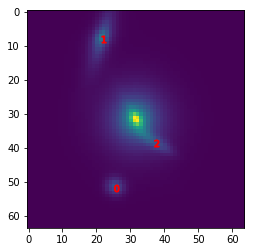

In [275]:
plot.scatter_galaxies(blend_noiseless[3], shift, 0.1, 64)

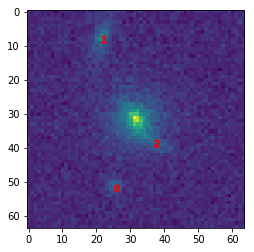

In [276]:
plot.scatter_galaxies(blend_noisy[3], shift, 0.1, 64)

## Compute blendedness rate

In [24]:
N = 100

blendedness_euclid = np.zeros((N,3))
max_blendedness_euclid = np.zeros((N))
blendedness_lsst = np.zeros((N,3))
max_blendedness_lsst = np.zeros((N))

blend_noiseless = np.zeros((100,10,64,64))

In [36]:
for i in range (N):
    print(i)
    galaxy_noiseless, galaxy_noisy, blend_noiseless[i], blend_noisy,shift, mag, blendedness_euclid[i], blendedness_lsst[i] = Gal_generator_noisy_test_2(cosmos_cat, 4, 'test')
    max_blendedness_euclid[i] = np.max(blendedness_euclid[i])
    max_blendedness_lsst[i] = np.max(blendedness_lsst[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


LogNormal as a function of hlr of centered galaxy

Uniform between (-1, 1) arcsecond

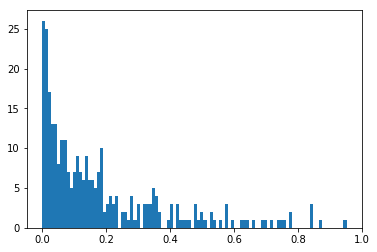

In [28]:
_ = plt.hist(np.concatenate(blendedness_euclid, axis = 0), bins = 100)

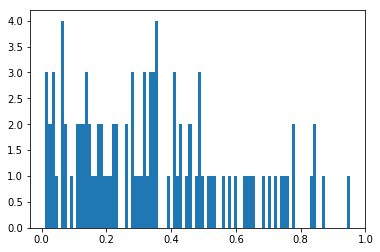

In [29]:
_ = plt.hist(max_blendedness_euclid, bins = 100)

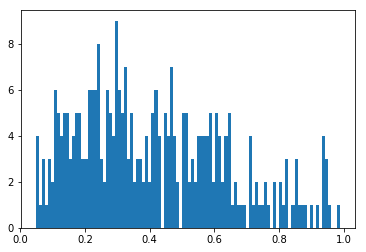

In [30]:
_ = plt.hist(np.concatenate(blendedness_lsst, axis = 0), bins = 100)

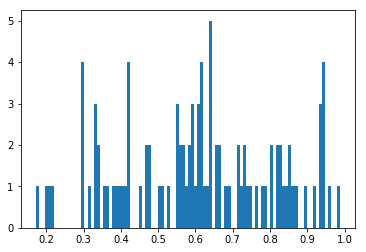

In [31]:
_ = plt.hist(max_blendedness_lsst, bins = 100)

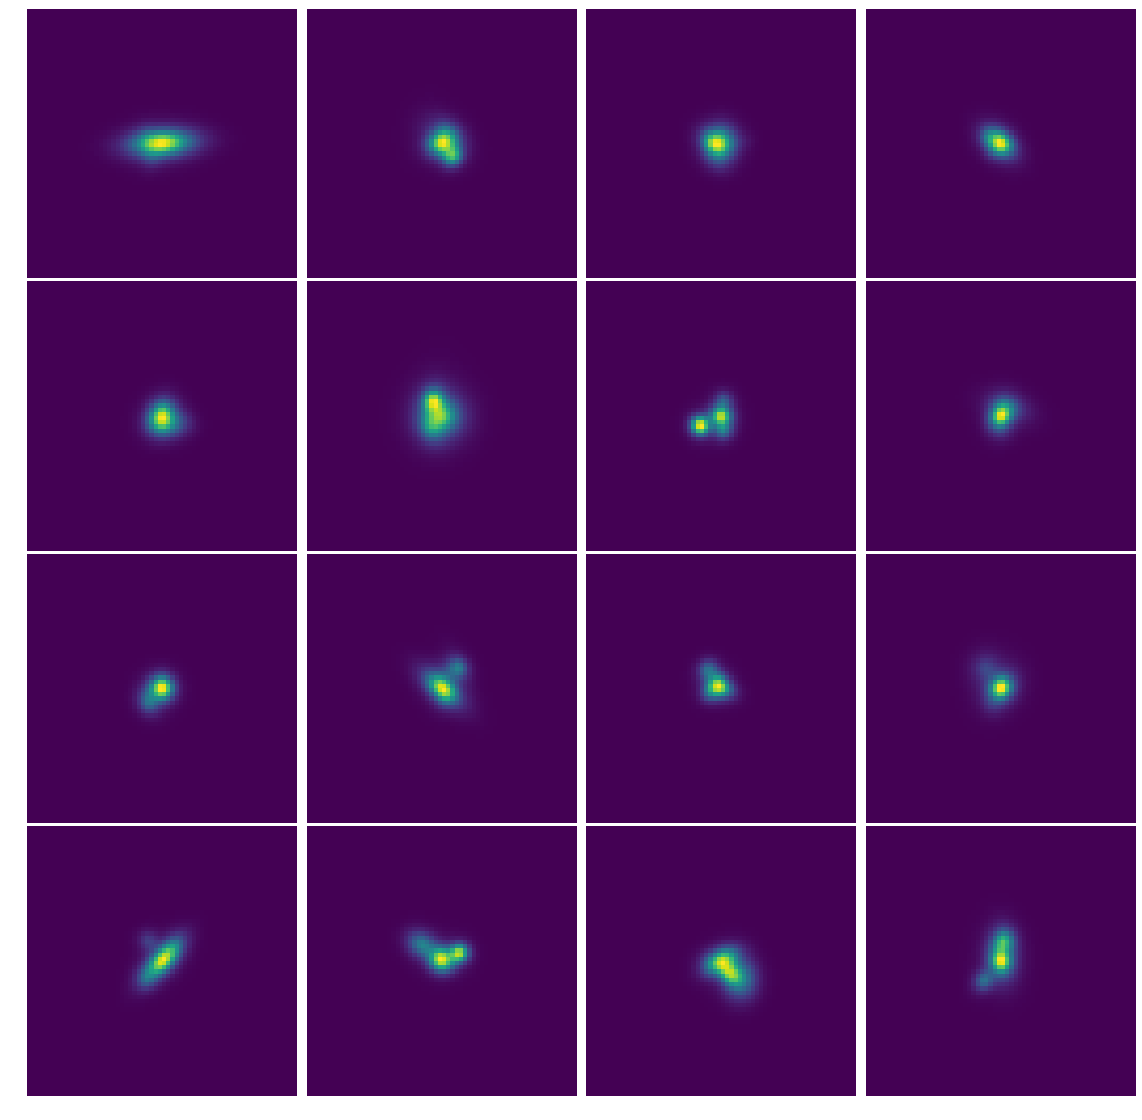

In [32]:
N_plot = 4
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        gal_1 = blend_noiseless[indices[i*N_plot+j]]    
        axes[i,j].imshow(gal_1[6])#
        axes[i,j].axis('off')

Uniform between (-2.5, 2.5) arcsecond

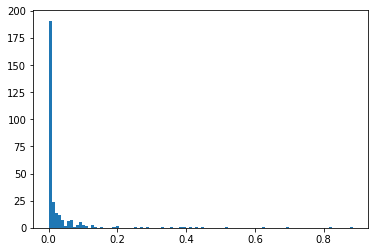

In [37]:
_ = plt.hist(np.concatenate(blendedness_euclid, axis = 0), bins = 100)

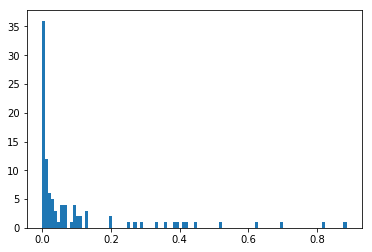

In [38]:
_ = plt.hist(max_blendedness_euclid, bins = 100)

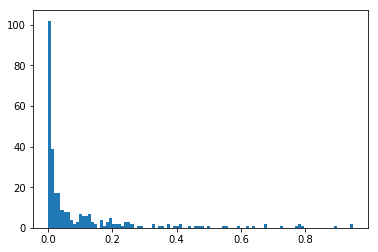

In [39]:
_ = plt.hist(np.concatenate(blendedness_lsst, axis = 0), bins = 100)

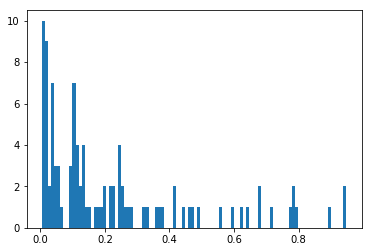

In [40]:
_ = plt.hist(max_blendedness_lsst, bins = 100)

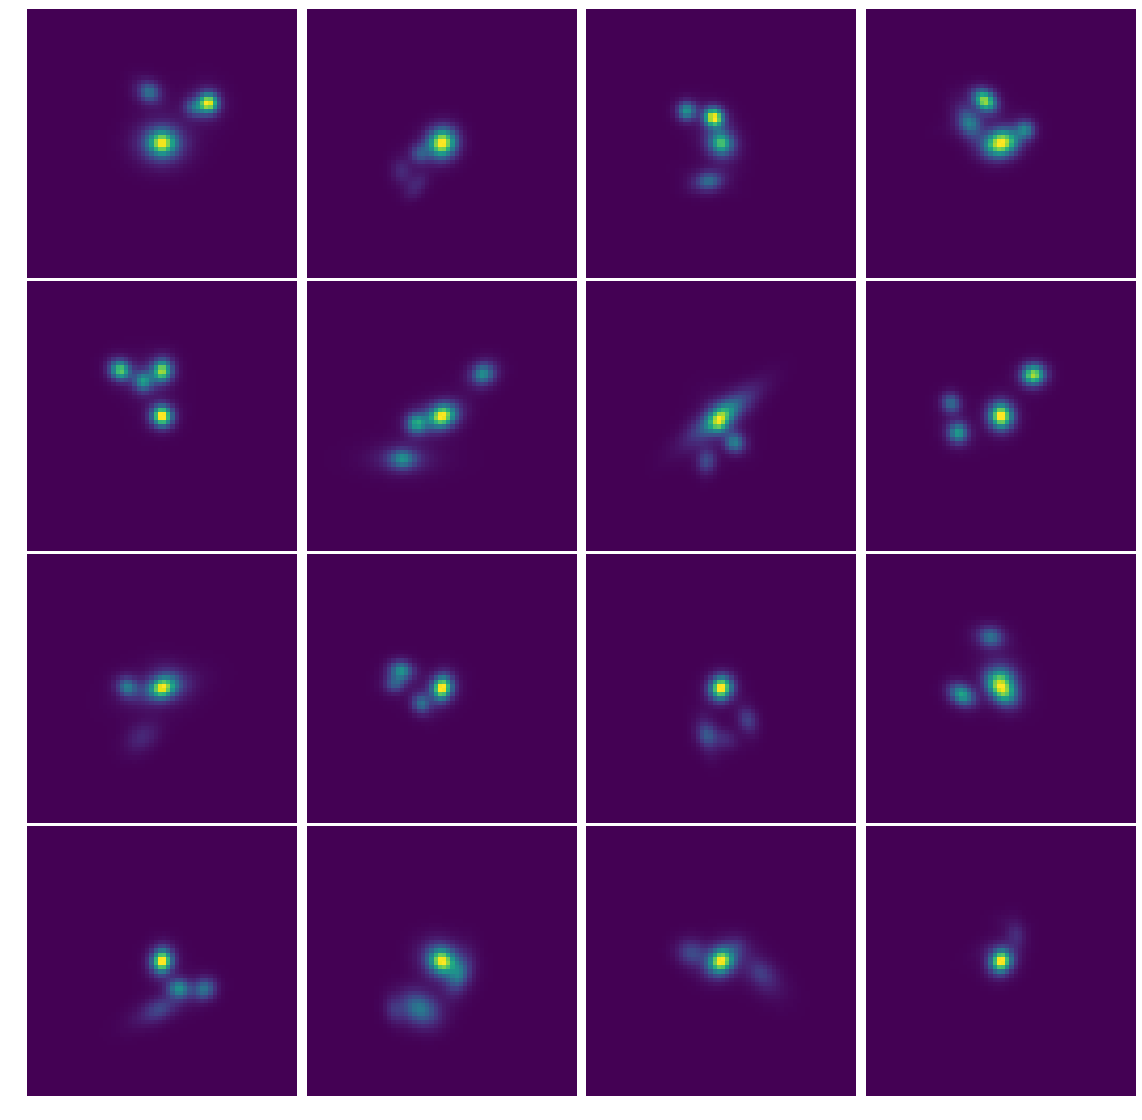

In [43]:
N_plot = 4
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        gal_1 = blend_noiseless[indices[i*N_plot+j]]    
        axes[i,j].imshow(gal_1[6])#
        axes[i,j].axis('off')

# Plot functions

In [49]:
def plot_rgb(name,ugrizy_img, ax=None):
    RGB_img = np.zeros((64,64,3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[4:])
    ugrizy_img = ugrizy_img.reshape(10,64,64)
    RGB_img[:,:,0] = ugrizy_img[5][:,:]
    RGB_img[:,:,1] = ugrizy_img[6][:,:]
    RGB_img[:,:,2] = ugrizy_img[8][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)
    ax.set_title(name)

In [9]:
def plot_rgb_nir(ugrizy_img, ax=None):
    RGB_img = np.zeros((64,64,3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[:3])
    ugrizy_img = ugrizy_img.reshape(10,64,64)
    RGB_img[:,:,0] = ugrizy_img[0][:,:]
    RGB_img[:,:,1] = ugrizy_img[1][:,:]
    RGB_img[:,:,2] = ugrizy_img[2][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

In [10]:
def plot_rgb_lsst(ugrizy_img, ax=None):
    RGB_img = np.zeros((64,64,3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[4:])
    ugrizy_img = ugrizy_img.reshape(10,64,64)
    RGB_img[:,:,0] = ugrizy_img[5][:,:]
    RGB_img[:,:,1] = ugrizy_img[6][:,:]
    RGB_img[:,:,2] = ugrizy_img[8][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

In [11]:
def plot_rgb_r_band(name,ugrizy_img, ax=None):
    RGB_img = np.zeros((64,64,1))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[6])
    ugrizy_img = ugrizy_img.reshape(1,64,64)
    RGB_img[:,:,0] = ugrizy_img[0][:,:]
    ax.imshow(ugrizy_img[0] / max_img)
    ax.set_title(name)

# Plot test

In [10]:
nb_blended_gal = np.random.randint(1,4)
print(nb_blended_gal)
test =  Gal_generator_noisy(cosmos_cat, nb_blended_gal)

1


(-0.5, 63.5, 63.5, -0.5)

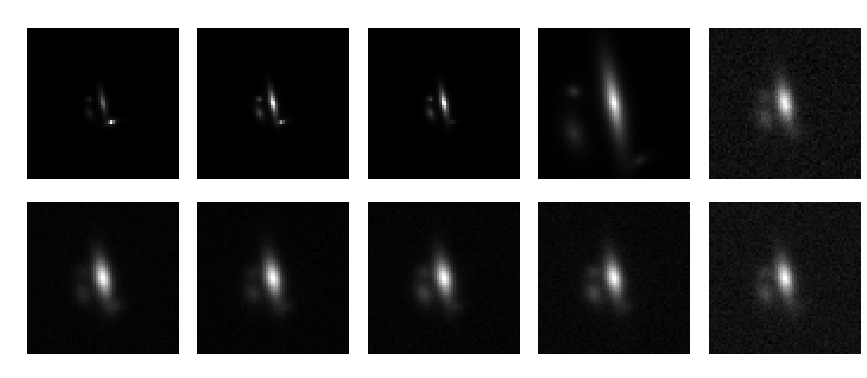

In [17]:
#N_plot = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(wspace=.1, hspace=.15)

galaxy_noiseless, galaxy_noisy, blend_noiseless, blend_noisy,shift, redshift = Gal_generator_noisy(cosmos_cat, 5)
axes[0,0].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[0], cmap='gray') 
axes[0,1].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[1], cmap='gray') 
axes[0,2].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[2], cmap='gray') 
axes[0,3].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[3], cmap='gray') 
axes[0,4].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[4], cmap='gray') 
axes[1,0].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[5], cmap='gray') 
axes[1,1].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[6], cmap='gray') 
axes[1,2].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[7], cmap='gray') 
axes[1,3].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[8], cmap='gray') 
axes[1,4].imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[9], cmap='gray') 
axes[0,0].set_title('Y', fontsize=20, color = 'w')
axes[0,1].set_title('J', fontsize=20, color = 'w')
axes[0,2].set_title('H', fontsize=20, color = 'w')
axes[0,3].set_title('VIS', fontsize=20, color = 'w')
axes[0,4].set_title('u', fontsize=20, color = 'w')
axes[1,0].set_title('g', fontsize=20, color = 'w')
axes[1,1].set_title('r', fontsize=20, color = 'w')
axes[1,2].set_title('i', fontsize=20, color = 'w')
axes[1,3].set_title('z', fontsize=20, color = 'w')
axes[1,4].set_title('y', fontsize=20, color = 'w')
axes[0,0].axis('off')
axes[0,1].axis('off')
axes[0,2].axis('off')
axes[0,3].axis('off')
axes[0,4].axis('off')
axes[1,0].axis('off')
axes[1,1].axis('off')
axes[1,2].axis('off')
axes[1,3].axis('off')
axes[1,4].axis('off')


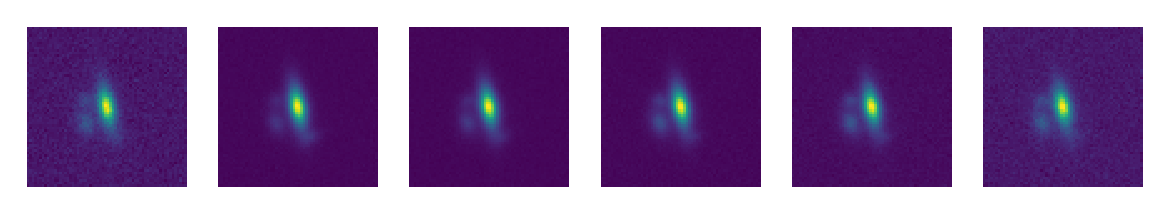

In [18]:
fig=plt.figure(figsize=(20,10))
rows, columns = 1,6
cont = 0
filters =['N','I','R','vis','u','g','r','i','z','y']

for i in range(4,10) :
    cont +=1
    fig.add_subplot(rows, columns, cont)
    
    plt.imshow(blend_noisy.reshape(10,stamp_size,stamp_size)[i])#/max_b)
    plt.title(filters[i], color="w", fontsize=20)
    plt.axis('off')

In [332]:
test[4],test[5]

(array([], shape=(0, 2), dtype=float64), 3.232800006866455)

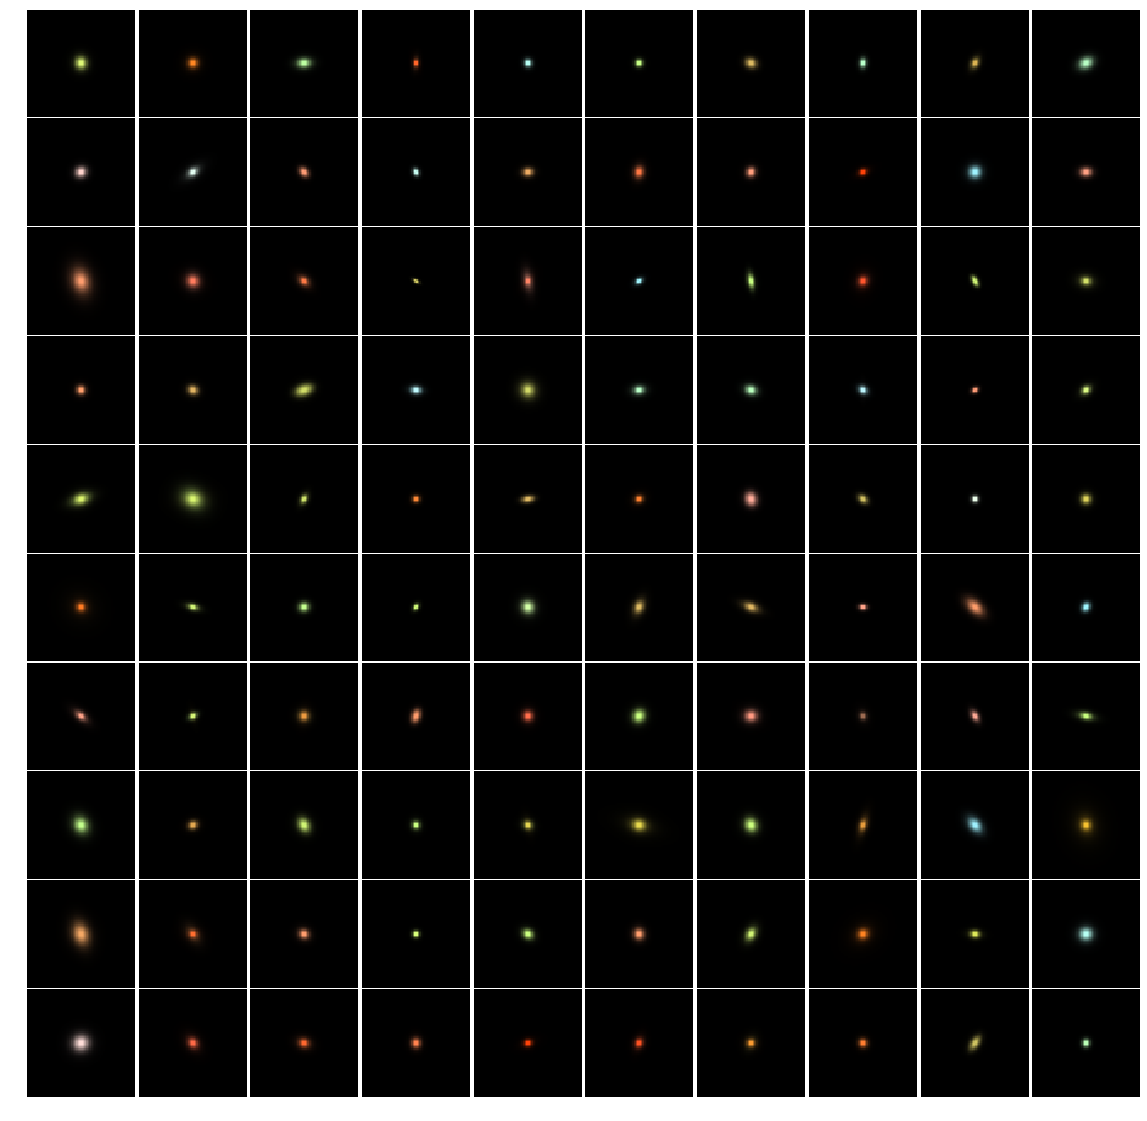

In [333]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        #print(i+j)
        # use the generator/decoder trained to create 2 images of one galaxy
        nb_blended_gal = np.random.randint(1,5)
        #print(nb_blended_gal)
        x_decoded_1 = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
        #print(x_decoded_1.shape)
        gal_1 = x_decoded_1[0].reshape(10,64, 64)    

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

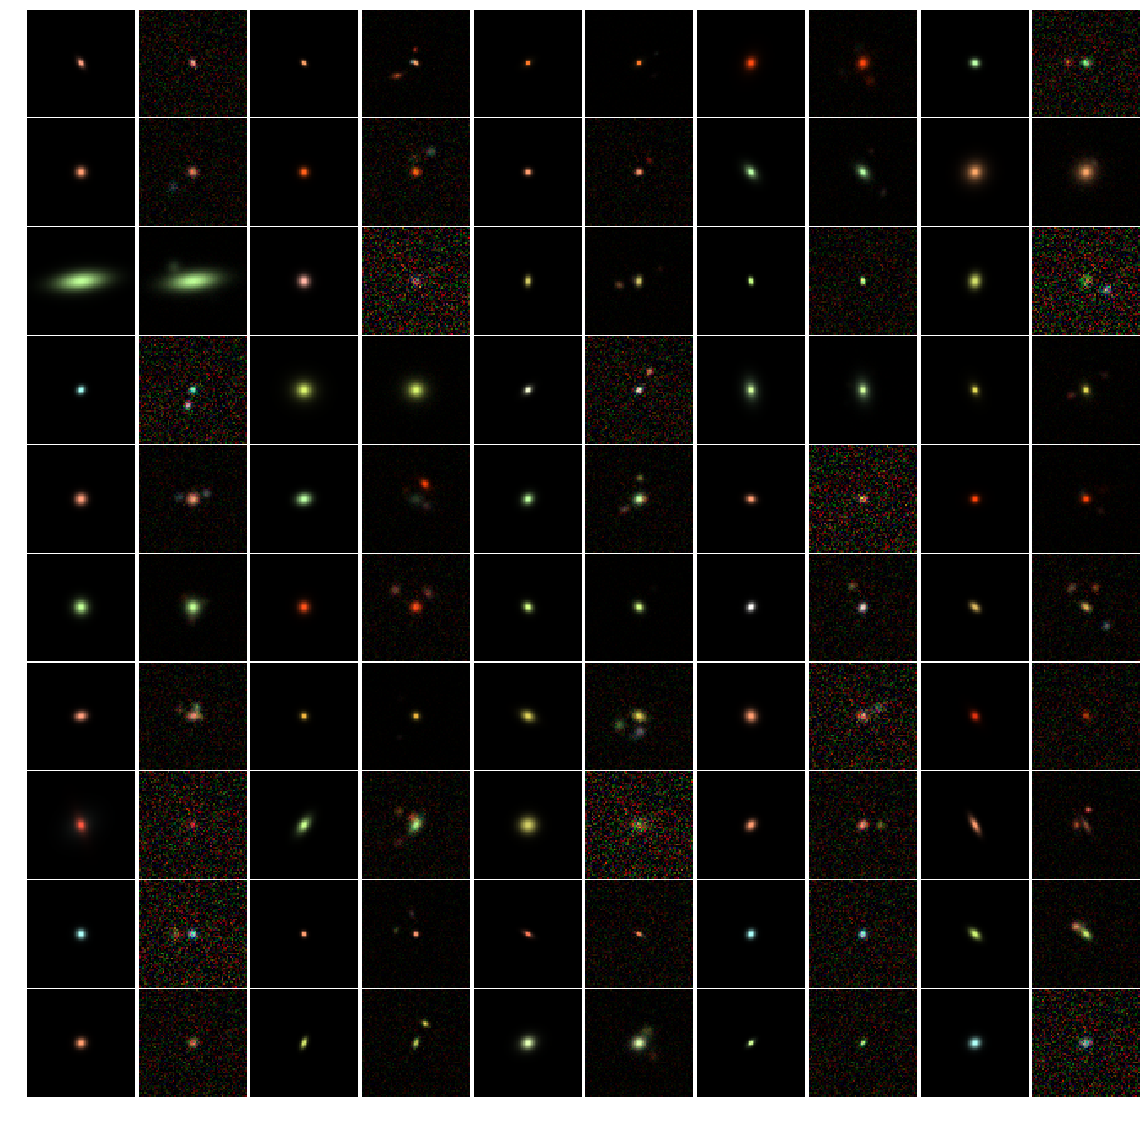

In [31]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        #print(i+j)
        # use the generator/decoder trained to create 2 images of one galaxy
        nb_blended_gal = np.random.randint(1,5)
        #print(nb_blended_gal)
        x_decoded_1 = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
        #print(x_decoded_1.shape)
        gal_1 = x_decoded_1[0].reshape(10,64, 64)    
        blend_n = x_decoded_1[3].reshape(10,64, 64)    
        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])
        plot_rgb_lsst(blend_n.reshape(10,64,64), ax=axes[i,j+1])
        axes[i,j].axis('off')
        axes[i,j+1].axis('off')

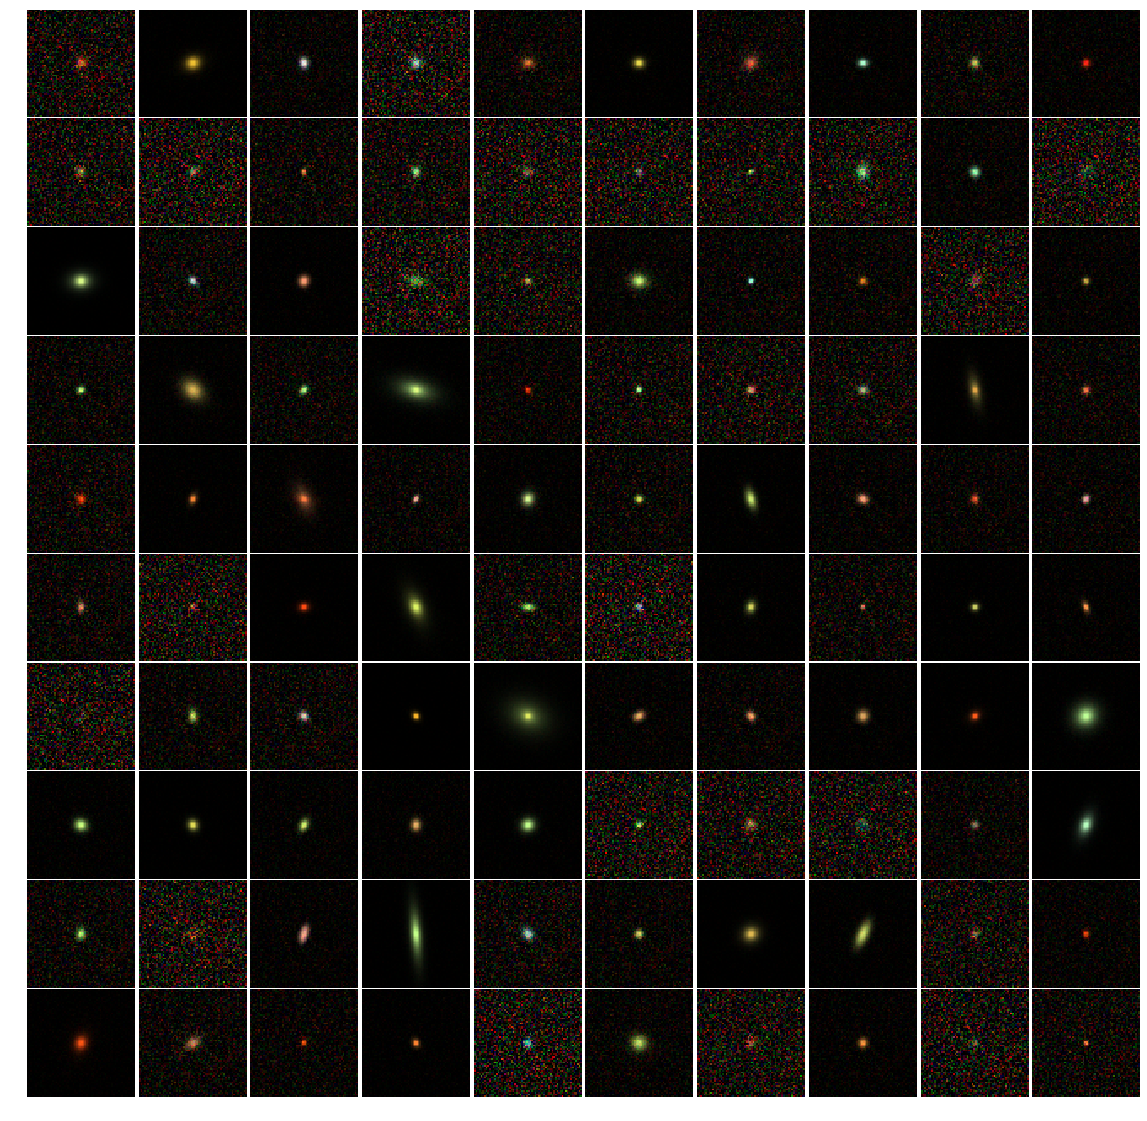

In [334]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(2000, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        
        # use the generator/decoder trained to create 2 images of one galaxy
        nb_blended_gal = np.random.randint(1,5)
        x_decoded_1 = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
        #print(x_decoded_1.shape)
        gal_1 = x_decoded_1[1].reshape(10,64, 64)    

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

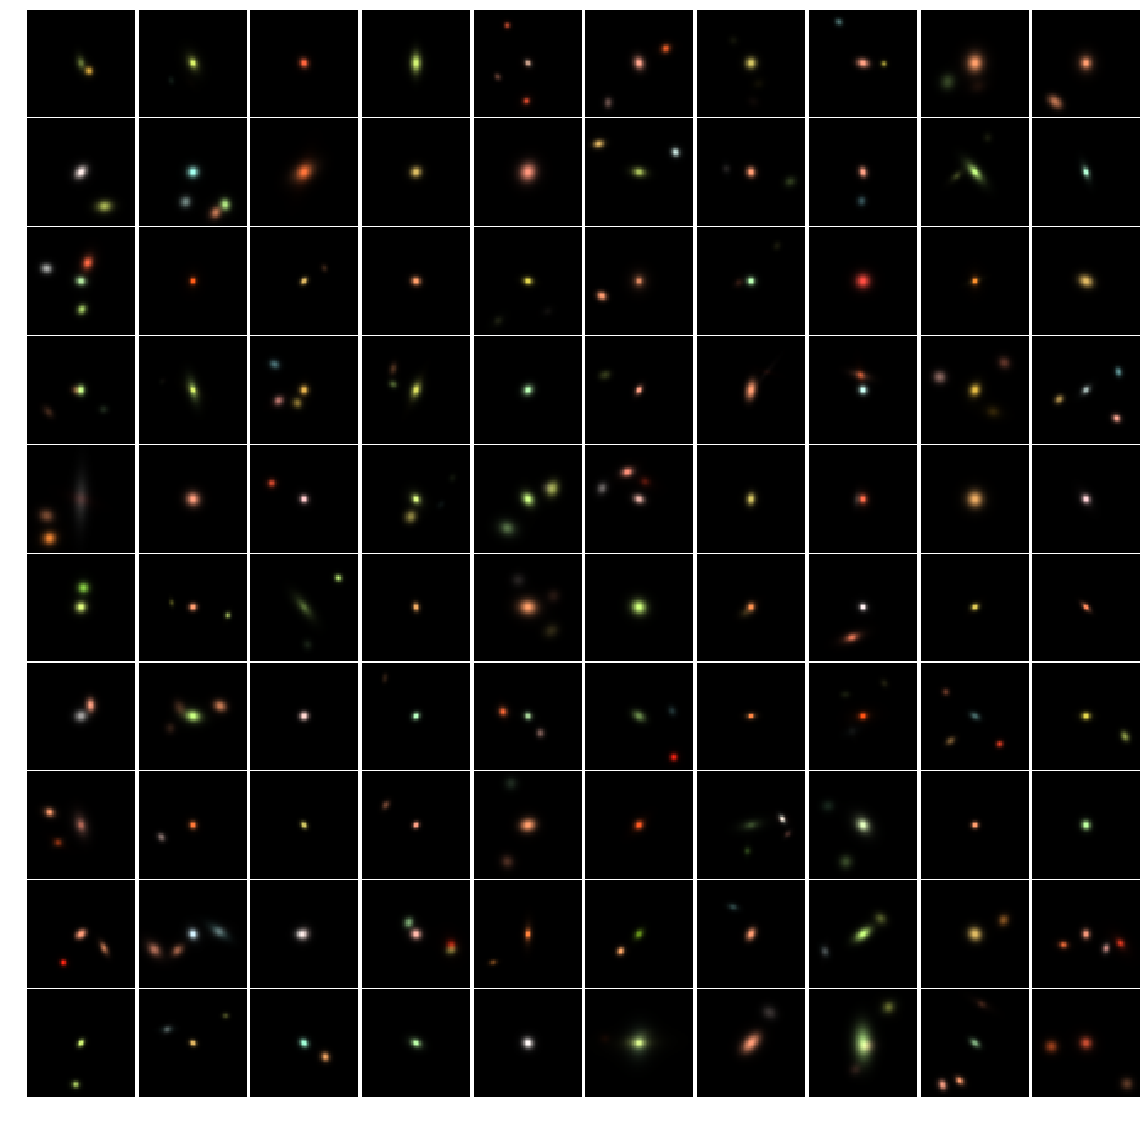

In [335]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(2000, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        
        # use the generator/decoder trained to create 2 images of one galaxy
        nb_blended_gal = np.random.randint(1,5)
        x_decoded_1 = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
        #print(x_decoded_1.shape)
        gal_1 = x_decoded_1[2].reshape(10,64, 64)    

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

### Check that maximum magnitude is in the center i R band

[]
[[-2.06267637 -1.32971728]
 [-1.61953304 -1.00061203]
 [-0.30916746  0.22489743]]
[]
[[ 0.05687353  1.5223564 ]
 [-1.93232106 -0.43537262]]
[[-0.0384772  -0.55774142]
 [ 2.24592527  1.27471486]]
[]
[[-1.57623052 -1.20969351]]
[[-0.95307077  1.28281492]]
[[ 1.45416632 -0.55734106]]
[[1.62163622 2.2752591 ]
 [1.97517328 0.61730353]]
[[ 0.55790041  1.66724903]
 [-1.44306074  2.44635341]
 [ 0.06939099 -2.09658351]]
[[ 0.33080555 -0.70011792]
 [-1.39705311 -1.58110447]
 [-0.25561951 -0.38500973]]
[[ 1.04551804 -0.12969347]]
[[ 0.92792818 -0.22867812]]
[]
[[-2.26084917  1.71847541]]
[]
[[-1.65467303 -0.47176534]]
[]
[[-1.56702891  0.34078461]]
[]
[]
[]
[]
[[1.19427417 0.93945974]
 [1.37434245 0.15003434]]
[]
[[ 0.88751013 -0.96122351]
 [-1.68541562 -0.30138626]
 [ 0.67448564 -1.7762072 ]]
[[-1.53203104 -1.1520931 ]
 [ 2.15465551 -2.35789373]
 [ 0.45978275  1.92204436]]
[[ 0.86872962  1.09599548]
 [-0.559882    1.1752229 ]
 [-0.27686961  2.12936215]]
[[-0.06210696  0.98251284]]
[[1.2978257

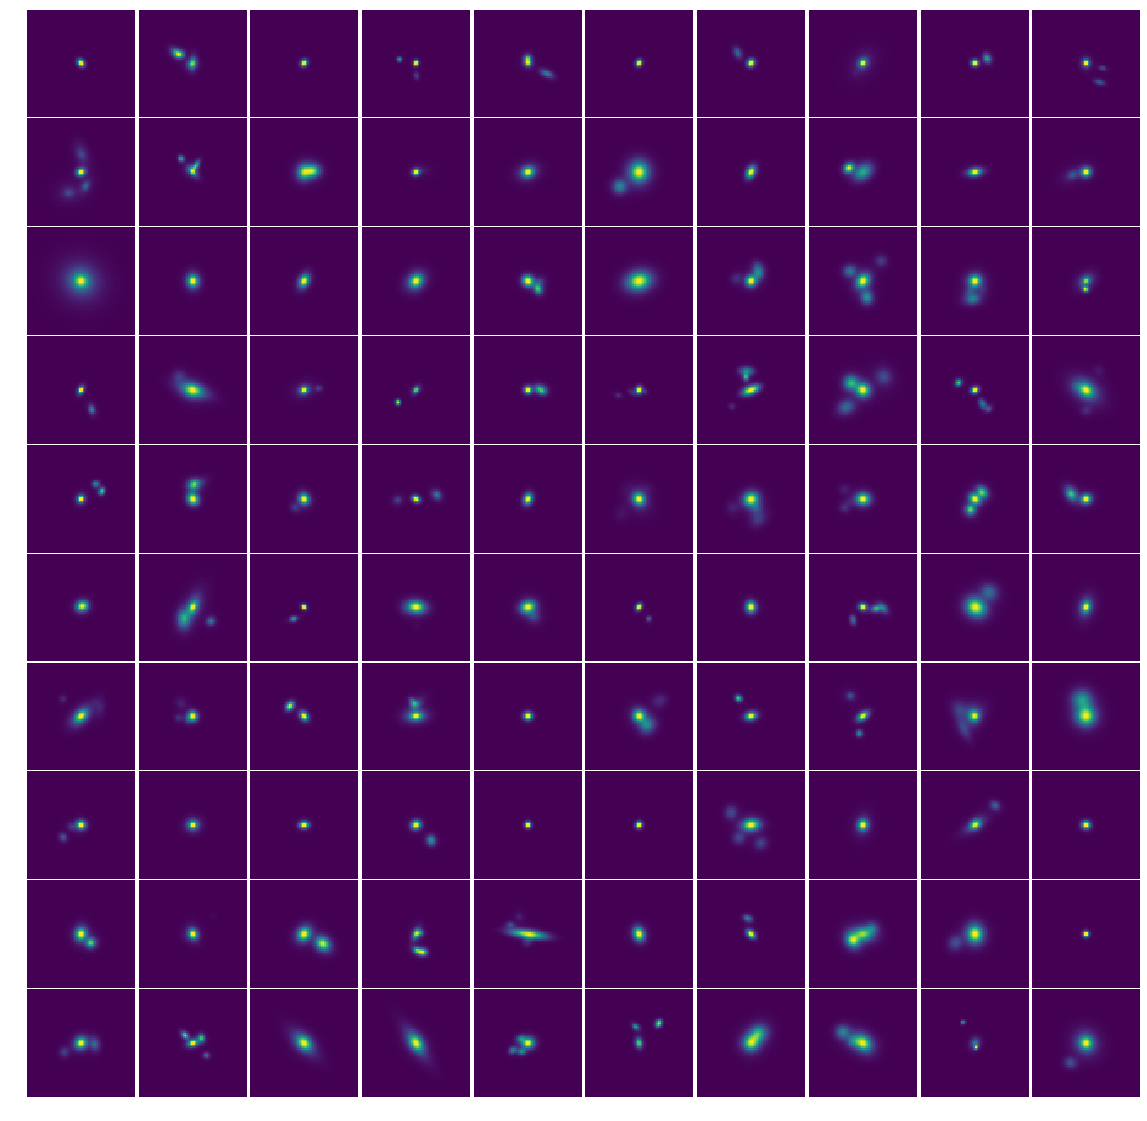

In [13]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(2000, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        
        # use the generator/decoder trained to create 2 images of one galaxy
        nb_blended_gal = np.random.randint(1,5)
        x_decoded_1 = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
        #print(x_decoded_1.shape)
        gal_1 = x_decoded_1[2].reshape(10,64, 64)    
        print(x_decoded_1[4])
        axes[i,j].imshow(gal_1.reshape(10,64,64)[6])#
        axes[i,j].axis('off')

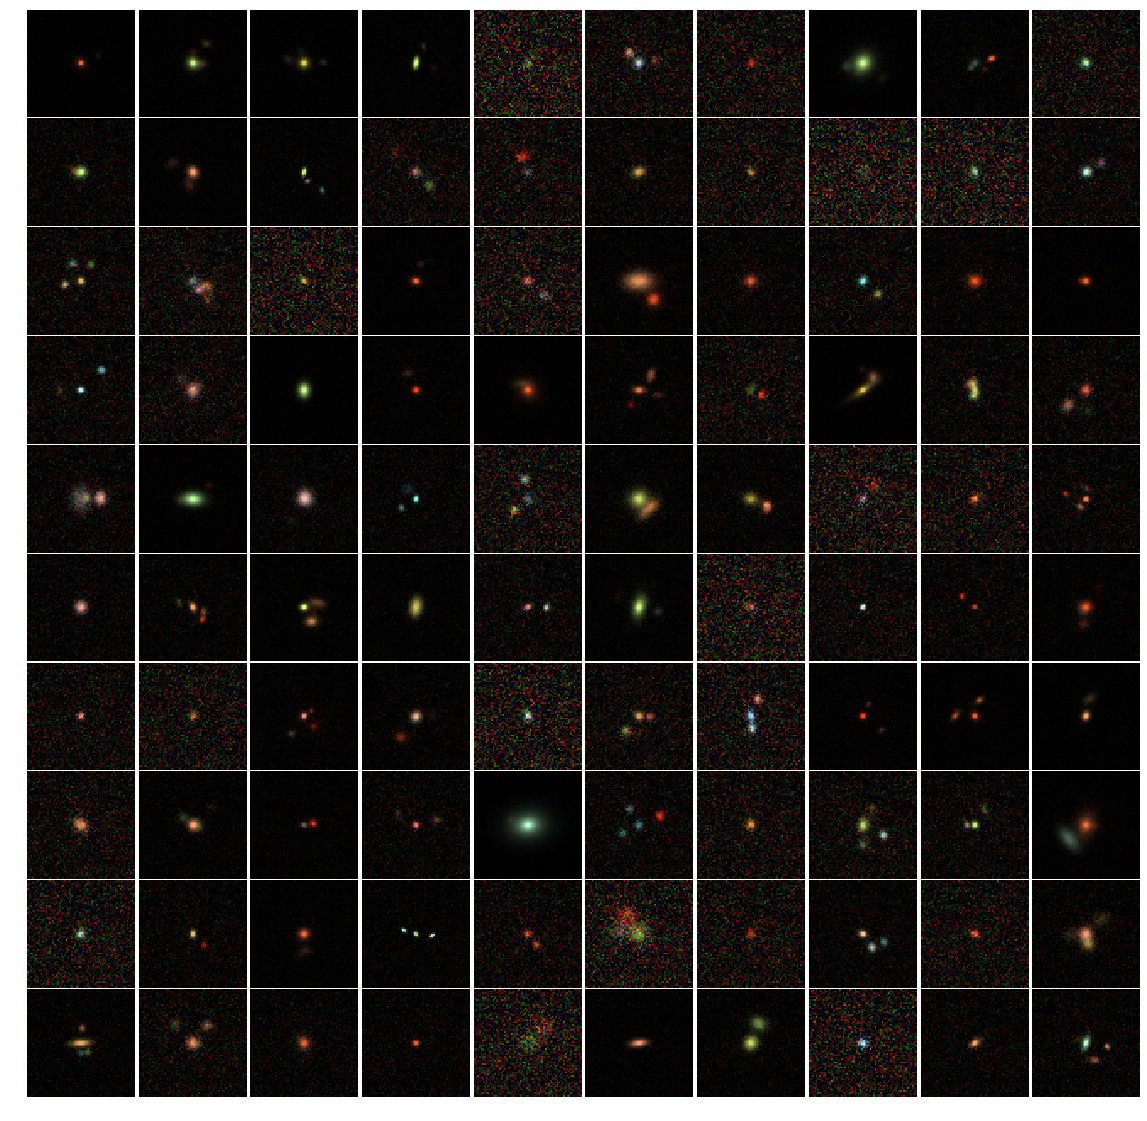

In [22]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(2000, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        
        # use the generator/decoder trained to create 2 images of one galaxy
        nb_blended_gal = np.random.randint(1,5)
        x_decoded_1 = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
        #print(x_decoded_1.shape)
        gal_1 = x_decoded_1[3].reshape(10,64, 64)    

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

# Paralleled generation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import sys
import os
import logging
import galsim
import cmath as cm
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
import scipy
import scipy.integrate 
from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
#from cosmos_generation import Gal_generator_noisy, Gal_generator_noisy_pix_same
from multiprocess import *

In [9]:
# Parameters to fix
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Loading the COSMOS catalog
cosmos_cat = galsim.COSMOSCatalog('real_galaxy_catalog_25.2.fits', dir='/sps/lsst/users/barcelin/COSMOS_25.2_training_sample')

In [10]:
# function to check if S/N > 2
# Here we do the detection in R band of LSST
def SNR(gal_noiseless,gal_noisy):
    condition = False
    max_img_noisy = np.max(gal_noisy[6])
    max_img_noiseless = np.max(gal_noiseless[6])
    
    snr = abs(max_img_noiseless/(max_img_noisy-max_img_noiseless))
    if snr>2 : 
        condition = True
    else:
        condition = False

    return condition

In [11]:
import multiprocessing
import time

def map_f(args):
    f, i, v = args
    v.value += 1
    return f(i)
    
def map(func, iter, verbose=True, timesleep=15.0, timeout=None):
    """
    Maps the function func over the iterator iter in a multi-threaded way using the multiprocessing package
    
    func must be pickable, see https://docs.python.org/2/library/pickle.html#what-can-be-pickled-and-unpickled
    
    """
    pool = multiprocessing.Pool()
    m = multiprocessing.Manager()
    v = m.Value(int, 0)
    
    inputs = ((func,i,v) for i in iter) #use a generator, so that nothing is computed before it's needed :)
    
    res = pool.map_async(map_f, inputs)
    
    try :
        n = len(iter)
    except TypeError : # if iter is a generator
        n = None

    if verbose :
        while (True):
            if (res.ready()): break
            # remaining = res._number_left
            # print "Waiting for", remaining, "task chunks to complete..."
            print("# castor.parallel.map : tasks accomplished out of {0} : {1}".format(n, v.get()))
            time.sleep(timesleep)

    pool.close()
    m.shutdown()

    return res.get(timeout)

In [12]:
count = 0
N_cosmo = 1000
N_per_gal = 5

ud = galsim.UniformDeviate()
rng = galsim.BaseDeviate()

counter = 0

itr = np.arange(N_cosmo)

img_cube_list = []

import time


def func(ind):
    nb_blended_gal = np.random.randint(1,5)
    galaxy_noiseless, galaxy_noisy, blend_noiseless, blend_noisy,shift, redshift = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
    if (SNR(galaxy_noiseless, galaxy_noisy,) == True):
        return np.array((galaxy_noiseless, galaxy_noisy, blend_noiseless, blend_noisy,shift, redshift))
    else:
        return func(ind+1) 



In [13]:
debut = time.time()

img_cube_list = map(func, itr,timesleep = 10.0)# 

fin = time.time()
print('time : '+ str(fin-debut))

# castor.parallel.map : tasks accomplished out of 1000 : 0
# castor.parallel.map : tasks accomplished out of 1000 : 51
# castor.parallel.map : tasks accomplished out of 1000 : 104
# castor.parallel.map : tasks accomplished out of 1000 : 116
# castor.parallel.map : tasks accomplished out of 1000 : 147
# castor.parallel.map : tasks accomplished out of 1000 : 235
# castor.parallel.map : tasks accomplished out of 1000 : 307
# castor.parallel.map : tasks accomplished out of 1000 : 365
# castor.parallel.map : tasks accomplished out of 1000 : 442
# castor.parallel.map : tasks accomplished out of 1000 : 471
# castor.parallel.map : tasks accomplished out of 1000 : 503
# castor.parallel.map : tasks accomplished out of 1000 : 547
# castor.parallel.map : tasks accomplished out of 1000 : 589
# castor.parallel.map : tasks accomplished out of 1000 : 634
# castor.parallel.map : tasks accomplished out of 1000 : 692
# castor.parallel.map : tasks accomplished out of 1000 : 762
# castor.parallel.map : tas

In [14]:
np.save('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test.npy', img_cube_list)

### Test with for loop

In [18]:
debut = time.time()

images = []
while len(images)<100 :
    nb_blended_gal = np.random.randint(1,N_per_gal)
    galaxy_noiseless, galaxy_noisy, blend_noiseless, blend_noisy,shift, redshift = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
    if (SNR(galaxy_noiseless, galaxy_noisy,) == True):
        images.append((galaxy_noiseless, galaxy_noisy, blend_noiseless, blend_noisy,shift, redshift))
        
fin = time.time()
print('time : '+ str(fin-debut))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-2e13a189867e>", line 6, in <module>
    galaxy_noiseless, galaxy_noisy, blend_noiseless, blend_noisy,shift, redshift = Gal_generator_noisy(cosmos_cat, nb_blended_gal)
  File "<ipython-input-5-54d506356e3b>", line 287, in Gal_generator_noisy
    img.addNoise(poissonian_noise_lsst)
  File "/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/galsim/noise.py", line 38, in addNoise
    noise.applyTo(self)
  File "/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/galsim/noise.py", line 195, in applyTo
    return self._applyTo(image)
  File "/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/galsim/noise.py", line 337, in _applyTo
    self._pd.generat

KeyboardInterrupt: 

In [ ]:
len(images)

In [ ]:
len(images[1]), images[1][2].shape

In [ ]:
np.save('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test.npy', images)

# Test of recorded images

In [11]:
test = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_10_v3.npy')

In [13]:
test.shape

(20000, 2, 10, 64, 64)

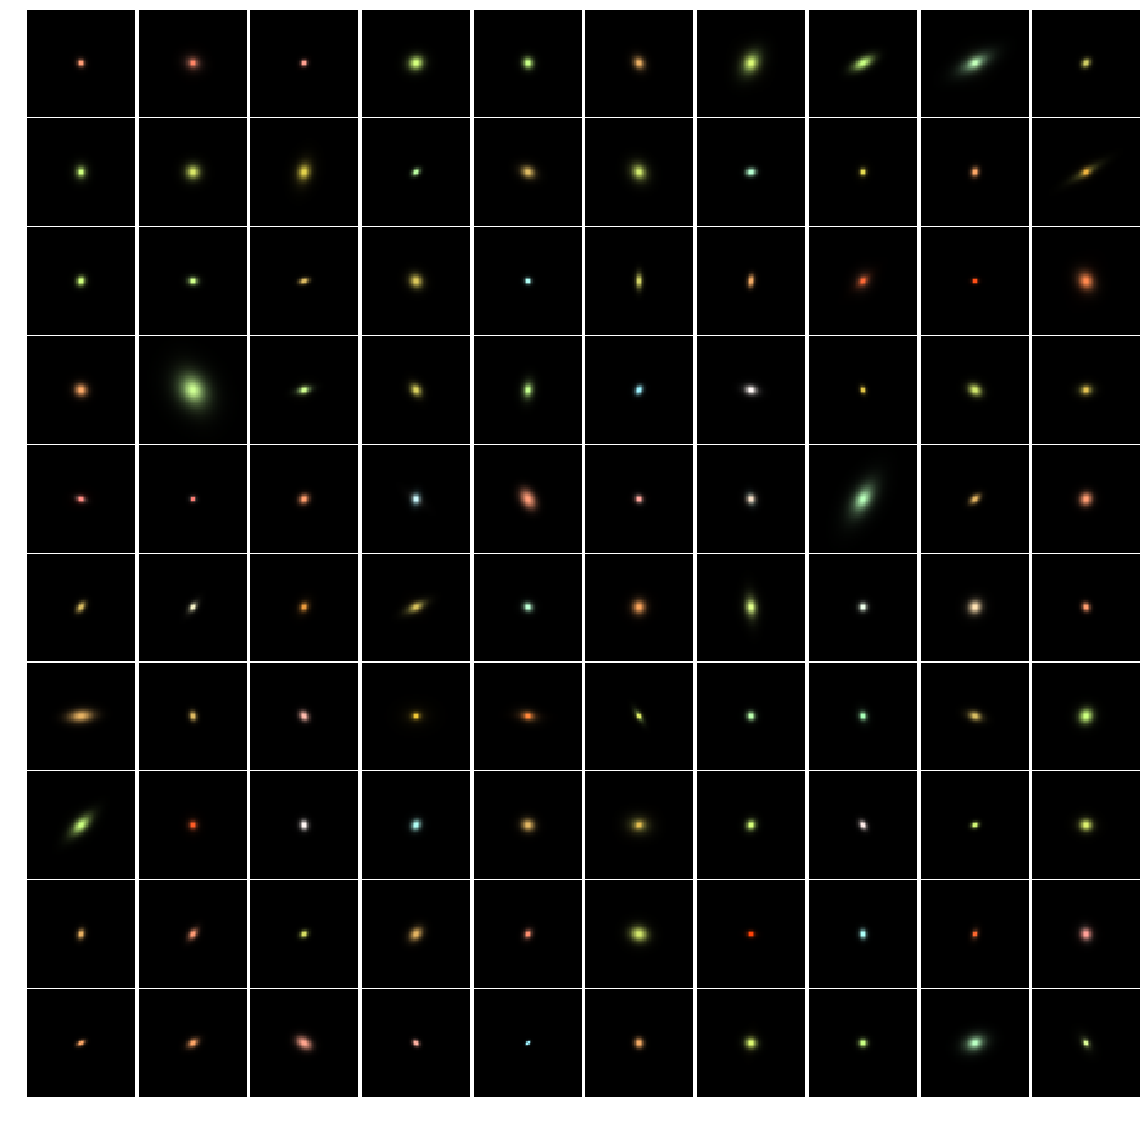

In [17]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        gal_1 = test[indices[i*N_plot+j]][0].reshape(10,64, 64)    

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

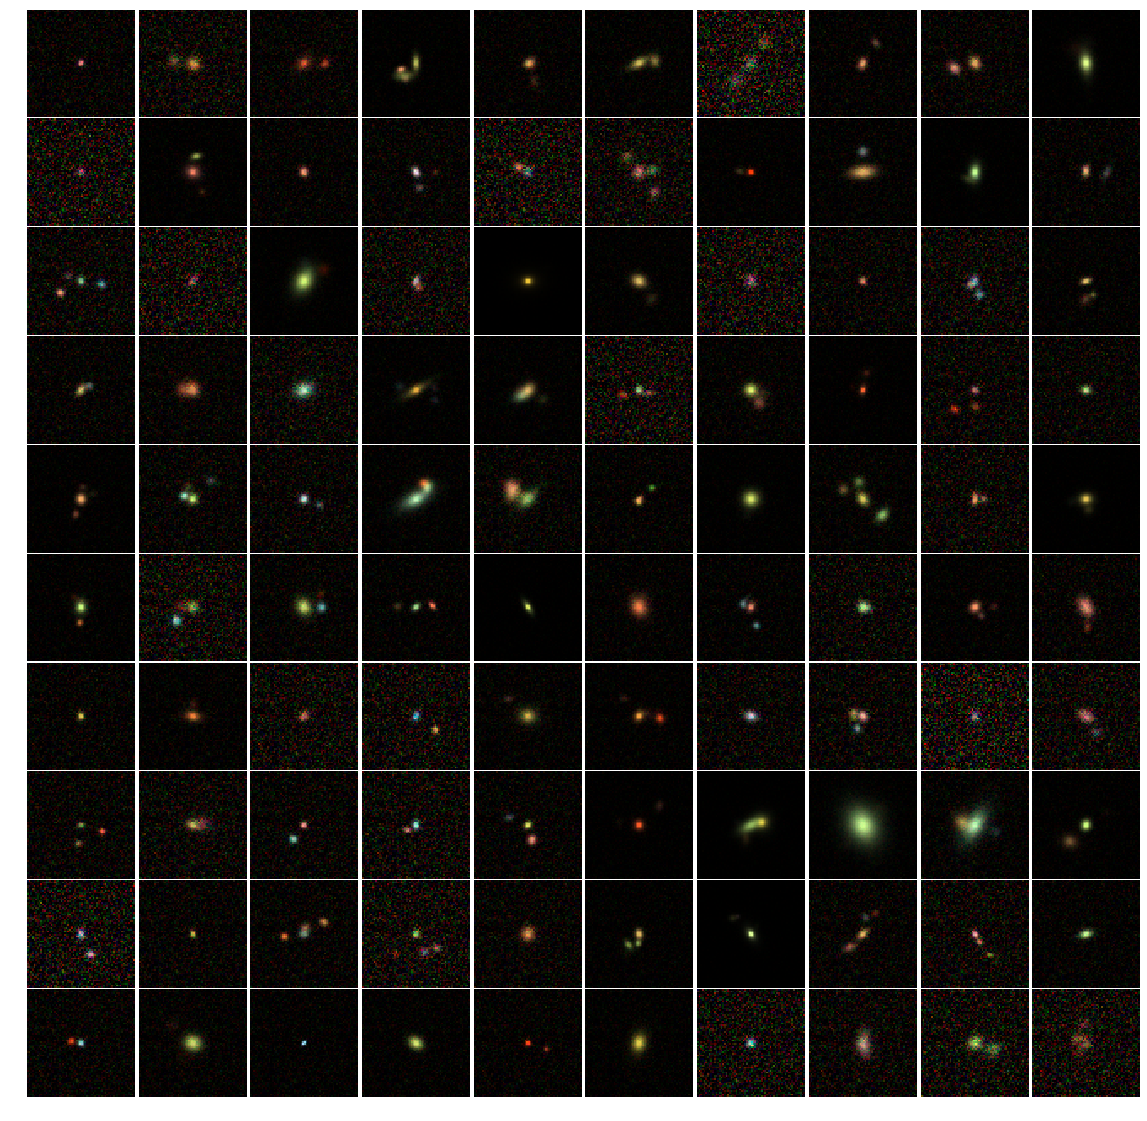

In [18]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        
        gal_1 = test[indices[i*N_plot+j]][1].reshape(10,64, 64)

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

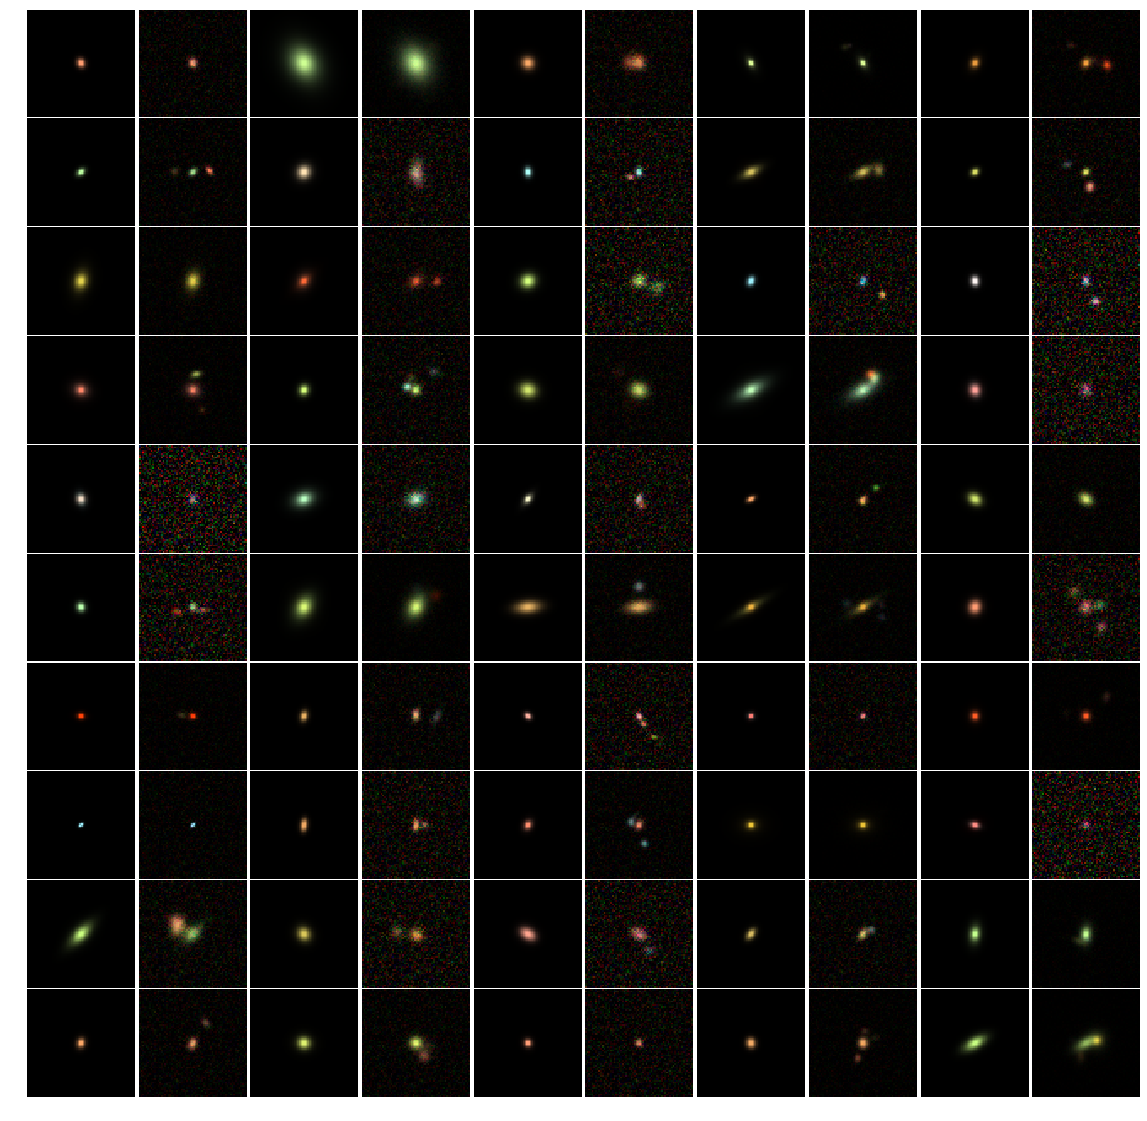

In [14]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):
        gal_1 = test[indices[i*N_plot+j]][0].reshape(10,64, 64)
        gal_b = test[indices[i*N_plot+j]][1].reshape(10,64, 64)
        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        plot_rgb_lsst(gal_b.reshape(10,64,64), ax=axes[i,j+1])#
        axes[i,j].axis('off')
        axes[i,j+1].axis('off')

IndexError: index 2 is out of bounds for axis 0 with size 2

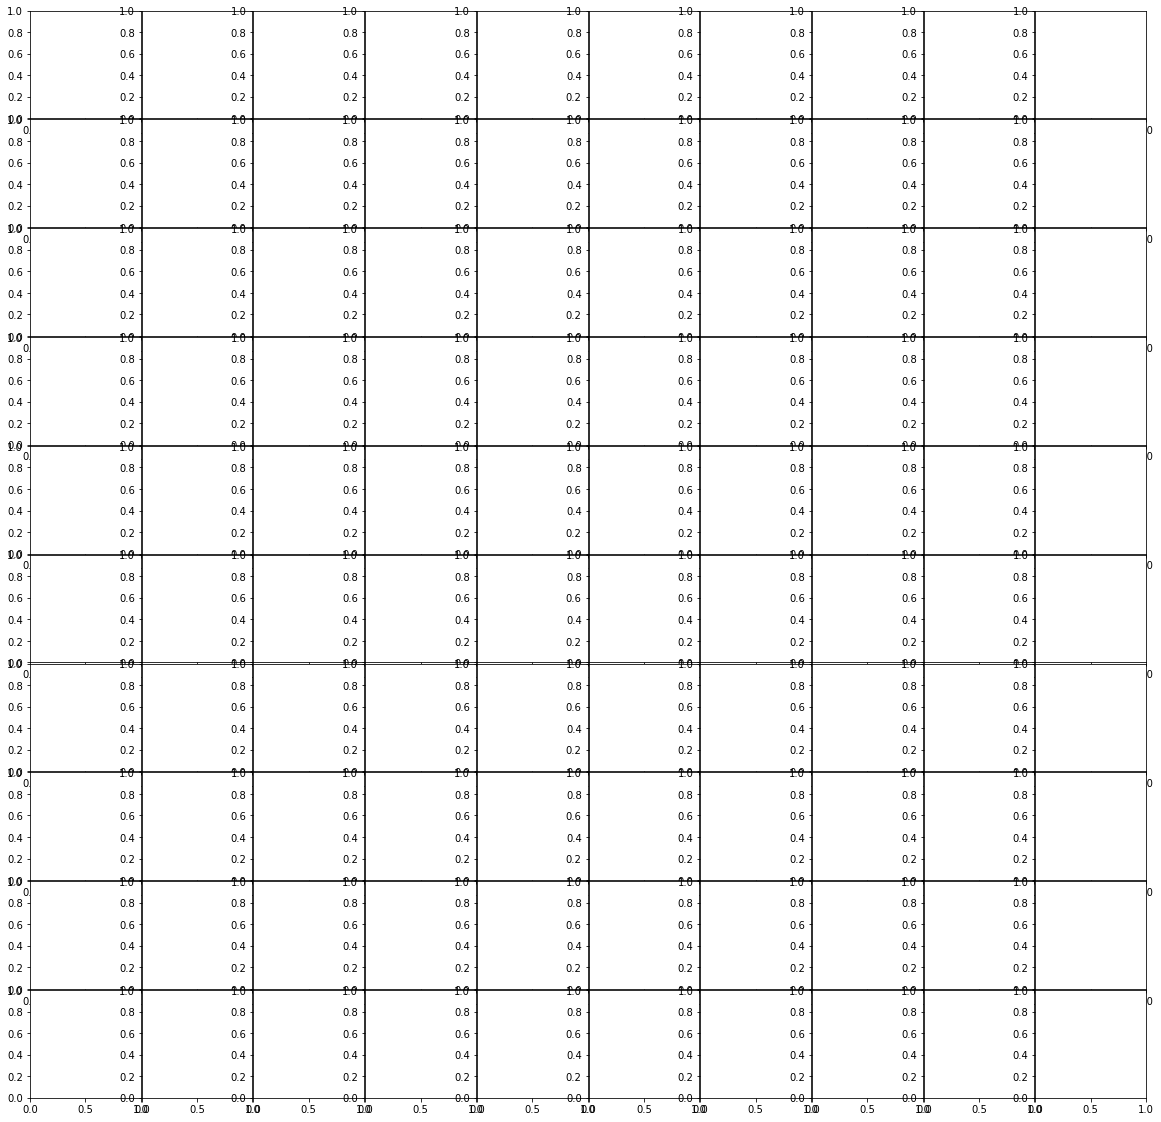

In [13]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        gal_1 = test[indices[i*N_plot+j]][2].reshape(10,64, 64)    

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

In [ ]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(N_plot):
        print(indices[i*N_plot+j])
        gal_1 = test[indices[i*N_plot+j]][3].reshape(10,64, 64)    

        plot_rgb_lsst(gal_1.reshape(10,64,64), ax=axes[i,j])#
        axes[i,j].axis('off')

In [198]:
883
955

955

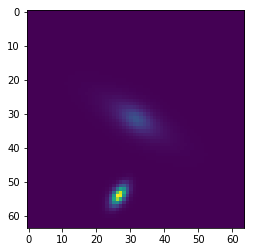

In [189]:
gal_1 = test[883][2].reshape(10,64, 64)
plt.imshow(gal_1[6])

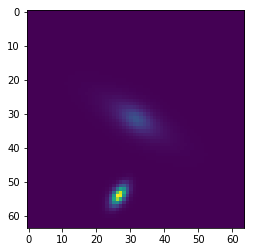

In [190]:
gal_2 = test[955][2].reshape(10,64, 64) 
plt.imshow(gal_1[6])

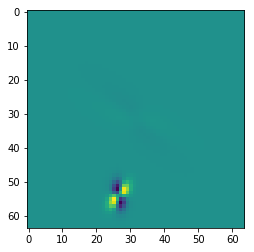

In [191]:
plt.imshow(gal_1[6]-gal_2[6])